In [1]:
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as pc


from sklearn.preprocessing import LabelEncoder

from torchvision import transforms as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
csv_path = "..\\clip_image\\train_data\\Dataset.csv"
data_frame = pd.read_csv(csv_path)

In [3]:
data_frame.head(2)

,image_name,width,height,label,x_min,y_min,x_max,y_max
0,D:\GitHub\coc_bot\src\base_downloader\layouts\...,1066,700,elixer_collector,437,169,490,213
1,D:\GitHub\coc_bot\src\base_downloader\layouts\...,1066,700,elixer_collector,568,150,624,206


In [4]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  388 non-null    object
 1   width       388 non-null    int64 
 2   height      388 non-null    int64 
 3   label       388 non-null    object
 4   x_min       388 non-null    int64 
 5   y_min       388 non-null    int64 
 6   x_max       388 non-null    int64 
 7   y_max       388 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 24.4+ KB


In [5]:
data_frame.columns

Index(['image_name', 'width', 'height', 'label', 'x_min', 'y_min', 'x_max',
       'y_max'],
      dtype='object')

In [6]:
def generate_labels(data):
    i = 1
    encoding = {}
    decodings = {}
    for each_data in data:
        encoding[each_data] = i
        decodings[i] = each_data
        i += 1
    return encoding, decodings

In [7]:
#label_encoder = LabelEncoder()
#data_frame['label'] = label_encoder.fit_transform(data_frame['label'])
label_mapper, label_inverse_mapper = generate_labels(data_frame['label'].unique().tolist())
data_frame['label'] = data_frame['label'].map(label_mapper)

In [8]:
label_inverse_mapper, len(label_inverse_mapper)

({1: 'elixer_collector', 2: 'gold_collector'}, 2)

In [9]:
#label_encoder.classes_

In [10]:
class ImageDataSet(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms
        self.image_names = self.data.image_name.unique()
    
    def __getitem__(self, idx):
        img_path = self.image_names[idx]
        img = Image.open(img_path)
        num_objs = self.data[self.data['image_name'] == img_path].shape[0]
        bbox = []
        labels = []
        for i in range(num_objs):
            x_min = self.data[self.data['image_name'] == img_path]['x_min'].iloc[i]
            x_max = self.data[self.data['image_name'] == img_path]['x_max'].iloc[i]
            y_min = self.data[self.data['image_name'] == img_path]['y_min'].iloc[i]
            y_max = self.data[self.data['image_name'] == img_path]['y_max'].iloc[i]
            target = self.data[self.data['image_name'] == img_path]['label'].iloc[i]
            bbox.append([x_min, y_min, x_max, y_max])
            labels.append(target)
        bbox = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        if self.transforms is not None:
            img = self.transforms(img)
            bbox[:, 0] = bbox[:, 0] * (224/self.data[self.data['image_name'] == img_path]['width'].iloc[0])
            bbox[:, 2] = bbox[:, 2] * (224/self.data[self.data['image_name'] == img_path]['width'].iloc[0])
            bbox[:, 1] = bbox[:, 1] * (224/self.data[self.data['image_name'] == img_path]['height'].iloc[0])
            bbox[:, 3] = bbox[:, 3] * (224/self.data[self.data['image_name'] == img_path]['height'].iloc[0])
        
        target = {}
        target["boxes"] = bbox
        target["labels"] = labels
        
        return img, target
    
    def __len__(self):
        return len(self.image_names)
        

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
transform = TF.Compose([
    TF.Resize((224, 224)),
    TF.ToTensor()
])
dataset_coc = ImageDataSet(data_frame, transform)

In [13]:
image, bbdata = dataset_coc[20]

In [14]:
def plot_image_with_bbox(image, bbox):
    plt.axes()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    for i in range(len(bbox['boxes'])):
        box = bbox['boxes'][i]
        x1, y1 = box[0], box[1]
        x2, y2 = box[2], box[3]
        rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec='red')
        plt.gca().add_patch(rectangle)
    plt.show()

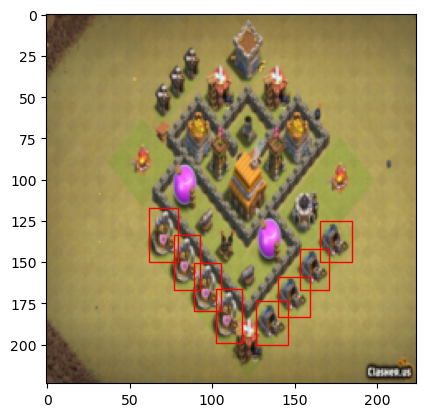

In [15]:
plot_image_with_bbox(image, bbdata)

In [16]:
dataloader = DataLoader(dataset=dataset_coc, batch_size=3, shuffle=False, collate_fn=collate_fn)

In [17]:
for batch_x, batch_y in dataloader:
    break

In [18]:
len(batch_x), len(batch_y)

(3, 3)

In [19]:
batch_y

({'boxes': tensor([[ 91.8274,  54.0800, 102.9644,  68.1600],
          [119.3546,  48.0000, 131.1219,  65.9200],
          [ 77.5385,  93.1200,  86.9944, 109.1200],
          [ 91.8274, 114.5600, 102.9644, 128.0000],
          [106.7467, 113.9200, 118.3039, 128.3200],
          [106.9568,  51.5200, 117.8837,  63.6800]]),
  'labels': tensor([1, 1, 1, 2, 2, 2])},
 {'boxes': tensor([[ 96.7750,  64.4000, 106.0500,  77.7778],
          [119.7000,  52.8889, 128.9750,  65.9556],
          [135.4500,  72.4889, 145.7750,  86.4889],
          [102.9000,  50.4000, 114.4500,  66.5778],
          [128.1000,  60.6667, 135.9750,  76.8444],
          [ 87.1500,  69.3778,  96.7750,  85.5556]]),
  'labels': tensor([2, 2, 2, 1, 1, 1])},
 {'boxes': tensor([[160.3579, 100.0533, 179.1499, 128.8000],
          [124.2774,  59.7333, 142.5682,  86.9867],
          [ 78.9262,  30.6133,  97.9687,  56.3733],
          [ 38.3356,  61.9733,  62.6398,  92.9600],
          [113.5033, 135.8933, 135.0515, 157.5467],
   

In [20]:
#Model
model = fasterrcnn_resnet50_fpn(weights=True)
model

C:\Users\gsuji\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [21]:
#Update RCNN Predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
out_features = len(label_mapper) + 1

model.roi_heads.box_predictor =  FastRCNNPredictor(in_features, out_features)

In [22]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=3, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
  )
)

In [23]:
#checking if model is working
model.eval()
output = model(batch_x[0].view(1, 3, 224, 224))

In [24]:
output

[{'boxes': tensor([[ 43.5643, 175.2150,  55.6488, 220.9298],
          [138.5117,  79.6610, 143.1087,  90.7517],
          [122.9726,  48.6605, 129.3236,  64.6406],
          [130.9760,  60.4219, 138.3734,  74.0520],
          [164.0475, 202.6855, 170.8912, 224.0000],
          [155.4838, 158.0950, 185.0085, 219.5987],
          [112.8732,   9.5473, 162.2209, 163.9460],
          [134.0974,  66.6180, 147.1261,  94.4086],
          [147.1765, 165.0635, 205.6247, 223.6458],
          [ 32.2895, 167.0276,  57.8570, 221.9170],
          [165.7378, 182.0070, 183.4816, 222.3314],
          [120.6677,  50.4169, 132.6765,  69.4515],
          [144.7968, 169.2007, 173.7831, 219.9612],
          [  3.8731,  68.4850,  43.7860, 222.7117],
          [ 34.5470, 181.0733,  51.2260, 220.3823],
          [171.6364, 175.4657, 193.6305, 224.0000],
          [163.2057, 205.2038, 177.5974, 224.0000],
          [139.0036,  80.8644, 148.0229,  92.0573],
          [ 69.7561,   0.0000, 195.9803, 208.8341],
   

In [25]:
model = model.to("cpu")

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [27]:
batch_y

({'boxes': tensor([[ 91.8274,  54.0800, 102.9644,  68.1600],
          [119.3546,  48.0000, 131.1219,  65.9200],
          [ 77.5385,  93.1200,  86.9944, 109.1200],
          [ 91.8274, 114.5600, 102.9644, 128.0000],
          [106.7467, 113.9200, 118.3039, 128.3200],
          [106.9568,  51.5200, 117.8837,  63.6800]]),
  'labels': tensor([1, 1, 1, 2, 2, 2])},
 {'boxes': tensor([[ 96.7750,  64.4000, 106.0500,  77.7778],
          [119.7000,  52.8889, 128.9750,  65.9556],
          [135.4500,  72.4889, 145.7750,  86.4889],
          [102.9000,  50.4000, 114.4500,  66.5778],
          [128.1000,  60.6667, 135.9750,  76.8444],
          [ 87.1500,  69.3778,  96.7750,  85.5556]]),
  'labels': tensor([2, 2, 2, 1, 1, 1])},
 {'boxes': tensor([[160.3579, 100.0533, 179.1499, 128.8000],
          [124.2774,  59.7333, 142.5682,  86.9867],
          [ 78.9262,  30.6133,  97.9687,  56.3733],
          [ 38.3356,  61.9733,  62.6398,  92.9600],
          [113.5033, 135.8933, 135.0515, 157.5467],
   

In [28]:
best_class_loss = best_regress_loss = np.inf;

In [29]:
model.train()
best_class_loss = best_regress_loss = np.inf;
for epoch in range(10):
    epoch_classif_loss = epoch_regress_loss = cnt = 0
    for batch_x, batch_y in dataloader:
        batch_x = list(image.to("cpu") for image in batch_x)
        batch_y = [{k: v.to("cpu") for k, v in t.items()} for t in batch_y]
        optimizer.zero_grad()
        loss_dict = model(batch_x, batch_y)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_classif_loss += loss_dict['loss_classifier'].item()
        epoch_regress_loss += loss_dict['loss_box_reg'].item()
        cnt += 1
    epoch_classif_loss /= cnt
    epoch_regress_loss /= cnt
    print("Training loss for epoch {} is {} for classification and {} for regression "
        .format(epoch + 1, epoch_classif_loss, epoch_regress_loss)
    )
    if (epoch_classif_loss <= best_class_loss) and (epoch_regress_loss <= best_regress_loss):
        print(f"Classification Loss has reduced from {best_class_loss} to {epoch_classif_loss} & \
        Regression Loss has reduced from {best_regress_loss} to {epoch_regress_loss} saving model.state")
        torch.save(model.state_dict(), ".\\save\\basic_model.pt")
        best_class_loss = epoch_classif_loss
        best_regress_loss = epoch_regress_loss

Training loss for epoch 1 is 0.4926377271904665 for classification and 0.5371385251774508 for regression 
Classification Loss has reduced from inf to 0.4926377271904665 &                 Regression Loss has reduced from inf to 0.5371385251774508 saving model.state
Training loss for epoch 2 is 0.20872773712172227 for classification and 0.44168292599565845 for regression 
Classification Loss has reduced from 0.4926377271904665 to 0.20872773712172227 &                 Regression Loss has reduced from 0.5371385251774508 to 0.44168292599565845 saving model.state
Training loss for epoch 3 is 0.10917134057073032 for classification and 0.3410909018095802 for regression 
Classification Loss has reduced from 0.20872773712172227 to 0.10917134057073032 &                 Regression Loss has reduced from 0.44168292599565845 to 0.3410909018095802 saving model.state
Training loss for epoch 4 is 0.10209903559264015 for classification and 0.32407743965878205 for regression 
Classification Loss has reduc

In [30]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [31]:
predict = model(batch_x[0].unsqueeze(0))
predict

[{'boxes': tensor([[ 77.4186, 106.9038,  90.5626, 130.4836],
          [152.5735, 109.1602, 164.5044, 129.4534],
          [128.1902, 175.5055, 140.2917, 193.9481],
          [128.1867,  16.6373, 139.8606,  36.9078],
          [ 80.8075, 151.2311,  93.5174, 171.1286],
          [142.2009,  55.8570, 156.7863,  74.4576],
          [169.2384, 116.5924, 183.8811, 136.5970],
          [ 96.7415,  33.1191, 108.8329,  50.1613],
          [148.1004, 151.7495, 163.0391, 172.4642],
          [ 87.3471,  48.0209, 100.4883,  67.2588],
          [ 95.3606,  30.1032, 108.5084,  52.0441]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2]),
  'scores': tensor([0.9931, 0.9925, 0.9904, 0.9881, 0.9851, 0.9819, 0.9803, 0.9771, 0.9716,
          0.9658, 0.0863], grad_fn=<IndexBackward0>)}]

In [32]:
label_inverse_mapper

{1: 'elixer_collector', 2: 'gold_collector'}

In [33]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision.transforms import ToPILImage

In [34]:
def predict(model, image, label, transform = transform):
    orignal_image = Image.open(image)
    width = orignal_image.width
    height = orignal_image.height
    processed_image = transform(orignal_image)
    transform_image = TF.Compose([TF.PILToTensor()])
    orignal_image = transform_image(orignal_image)
    model.eval()
    predited = model(processed_image.unsqueeze(0))
    labels = [label_inverse_mapper[each_lable] for each_lable in predited[0]['labels'].numpy().tolist()]
    predited[0]['boxes'][:, 0] = predited[0]['boxes'][:, 0] * (width/224)
    predited[0]['boxes'][:, 2] = predited[0]['boxes'][:, 2] * (width/224)
    predited[0]['boxes'][:, 1] = predited[0]['boxes'][:, 1] * (height/224)
    predited[0]['boxes'][:, 3] = predited[0]['boxes'][:, 3] * (height/224)
    img=draw_bounding_boxes(orignal_image, predited[0]['boxes'], width=3, labels= labels, fill =True, font_size=20)
    img = ToPILImage()(img)
    plt.imshow(img)
    return img.show()
    

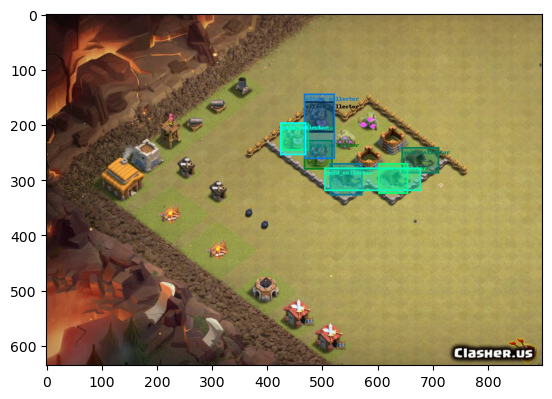

In [38]:
predict(model, r'D:\GitHub\coc_bot\src\base_downloader\layouts\th3\5e3c1c273e705904274efe97.jpg', transform)